In [1]:
import sys

sys.path.append('..')

from LoadData2 import loadNbackEmoidAgesScansAndGenders, loadMeta

pncDir = '../../PNC_Good'

keys, nbackTs, emoidTs, ages = loadNbackEmoidAgesScansAndGenders(loadMeta(f'{pncDir}/MegaMeta3.pkl'))

print(nbackTs.shape)
print(emoidTs.shape)
print(ages.shape)
print(ages[0:10])

(650, 264, 231)
(650, 264, 210)
(650,)
[ 9.66666667 15.58333333 15.83333333 20.16666667 11.41666667 11.58333333
  9.41666667 17.5        15.25        9.58333333]


In [2]:
# Get FC and convert to torch

from LoadData2 import getFC
import torch

nbackP = getFC(nbackTs)
emoidP = getFC(emoidTs)

nbackP_t = torch.from_numpy(nbackP).reshape(650,264*264).float().cuda()
emoidP_t = torch.from_numpy(emoidP).reshape(650,264*264).float().cuda()
feat_t = torch.cat([nbackP_t, emoidP_t], dim=1)
ages_t = torch.from_numpy(ages).float().cuda()

print(nbackP_t.shape)
print(emoidP_t.shape)
print(ages_t.shape)

torch.Size([650, 69696])
torch.Size([650, 69696])
torch.Size([650])


In [68]:
# Select a small sample

train_t = feat_t[200:250].reshape(-1,2*264*264)
full_t = feat_t[200:300].reshape(-1,2*264*264)
test_t = feat_t[250:300].reshape(-1,2*264*264)

print('Complete')

Complete


In [79]:
def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

# Cosine similarity

def cosineSim(a, b):
    nB = a.shape[0]
    e = torch.einsum('ai,bi->ab',a,b)
    aa = torch.einsum('ai,ai->a',a,a)**0.5
    bb = torch.einsum('bi,bi->b',b,b)**0.5
    e /= aa.unsqueeze(1)
    e /= bb.unsqueeze(1).T
    return normalize(e-torch.eye(nB).float().cuda())

Atrain = cosineSim(train_t, train_t) #+ torch.eye(100).float().cuda()
A = cosineSim(full_t, full_t) #+ torch.eye(200).float().cuda()

print(Atrain.shape)
print(A.shape)

torch.Size([50, 50])
torch.Size([100, 100])


In [80]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv

import numpy as np

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        #self.gc1 = nn.Linear(264*264,100).float().cuda()
        #self.gc2 = nn.Linear(100,1).float().cuda()
        self.gc1 = DenseGCNConv(2*264*264,100).float().cuda()
        self.gc2 = DenseGCNConv(100,1).float().cuda()
        self.loss = nn.MSELoss()

    def forward(self, x):
        A = x[0]
        z = x[1]
#         a = A@z
        a = F.relu(self.gc1(z,A))
#         a = A@a
        a = self.gc2(a,A)
        return a

gcn = GCN()
optim = torch.optim.Adam(gcn.parameters(), lr=1e-5, weight_decay=0.2) # 1e-5 and 0.2

nEpoch = 3000
pPrint = 200

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn([Atrain,train_t]).flatten()
    loss = gcn.loss(pred, ages_t[200:250])
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')

print(f'Complete GCN')

pred = gcn([A,full_t]).flatten()[50:].detach().cpu().numpy()
mae = np.mean(np.abs(pred-ages[250:300]))

print(f'MAE {mae}')

epoch 0 loss=243.83534240722656
epoch 200 loss=11.600600242614746
epoch 400 loss=6.772218704223633
epoch 600 loss=3.688652753829956
epoch 800 loss=1.6021997928619385
epoch 1000 loss=0.7394275665283203
epoch 1200 loss=0.3924081325531006
epoch 1400 loss=0.25738662481307983
epoch 1600 loss=0.17448827624320984
epoch 1800 loss=0.12870992720127106
epoch 2000 loss=0.11412008106708527
epoch 2200 loss=0.1046314388513565
epoch 2400 loss=0.09178468585014343
epoch 2600 loss=0.07789180427789688
epoch 2800 loss=0.06911689788103104
epoch 2999 loss=0.06306331604719162
Complete GCN
MAE 2.0554104423522954


In [75]:
# Train a contrastive loss network

import torch.nn as nn
import torch.nn.functional as F
import itertools
import random
import copy
import numpy as np

class ConGraph(nn.Module):
    def __init__(self):
        super(ConGraph, self).__init__()
        self.fc1 = nn.Linear(4*264*264,100).float().cuda()
        self.fc2 = nn.Linear(100,1).float().cuda()
        self.loss = nn.MSELoss()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cg = ConGraph()
optim = torch.optim.Adam(cg.parameters(), lr=1e-5, weight_decay=0)

nEpoch = 50
bSize = 1000
pPeriod = 2000

pairs = list(itertools.combinations_with_replacement(np.arange(50),2))
ages_train = ages_t[200:250]

for epoch in range(nEpoch):
    randPairs = copy.copy(pairs)
    random.shuffle(randPairs)
    nComplete = 0
    print(f'epoch {epoch}')
    while nComplete < len(pairs):
        todo = len(pairs)-nComplete
        if todo > bSize:
            todo = bSize
        batchPairs = randPairs[nComplete:nComplete+todo]
        Ai, Bi = zip(*batchPairs)
        A = train_t[Ai,:]
        B = train_t[Bi,:]
        a = ages_train[list(Ai)]
        b = ages_train[list(Bi)]
        optim.zero_grad()
        pos = torch.cat([A,B],dim=1)
        neg = torch.cat([B,A],dim=1)
        pres = cg(pos).flatten()
        nres = cg(neg).flatten()
        pp = pres-(a-b)
        nn = nres-(b-a)
        pLoss = cg.loss(pp, torch.zeros(todo).float().cuda())
        nLoss = cg.loss(nn, torch.zeros(todo).float().cuda())
        (pLoss+nLoss).backward()
        optim.step()
        if nComplete % pPeriod == 0 and epoch % 3 == 0:
            print(f'\tposLoss={pLoss} negLoss={nLoss}')
        nComplete += todo
        
print('Complete')

epoch 0
	posLoss=23.37589454650879 negLoss=23.379133224487305
epoch 1
epoch 2
epoch 3
	posLoss=18.31912612915039 negLoss=18.411087036132812
epoch 4
epoch 5
epoch 6
	posLoss=13.808244705200195 negLoss=13.630741119384766
epoch 7
epoch 8
epoch 9
	posLoss=10.259306907653809 negLoss=10.129566192626953
epoch 10
epoch 11
epoch 12
	posLoss=7.441886901855469 negLoss=7.400272846221924
epoch 13
epoch 14
epoch 15
	posLoss=5.532761096954346 negLoss=5.53701114654541
epoch 16
epoch 17
epoch 18
	posLoss=3.760880470275879 negLoss=3.704775094985962
epoch 19
epoch 20
epoch 21
	posLoss=2.5574707984924316 negLoss=2.5408902168273926
epoch 22
epoch 23
epoch 24
	posLoss=1.7493500709533691 negLoss=1.7115163803100586
epoch 25
epoch 26
epoch 27
	posLoss=1.152612328529358 negLoss=1.13459050655365
epoch 28
epoch 29
epoch 30
	posLoss=0.6978739500045776 negLoss=0.6841877698898315
epoch 31
epoch 32
epoch 33
	posLoss=0.4325886368751526 negLoss=0.4090536832809448
epoch 34
epoch 35
epoch 36
	posLoss=0.27930352091789246 

In [76]:
wp = np.zeros(50)
wn = np.zeros(50)

ram = torch.zeros(2*264*264, requires_grad=False).float().cuda()

for i in range(50):
    if i % 20 == 0:
        print(f'done {i}')
        
    A = test_t[i].expand(50,-1)

    B = train_t
    b = ages_t[200:250]

    cg.zero_grad()
    pos = torch.cat([A,B],dim=1)
    neg = torch.cat([B,A],dim=1)
    pres = cg(pos).flatten()
    nres = cg(neg).flatten()

    wp[i] = torch.mean(pres + b).detach().cpu().numpy()
    wn[i] = torch.mean(b - nres).detach().cpu().numpy()
    
#     lossp = (ages_t[200+i]-wp)**2
#     lossn = (ages_t[200+i]-wn)**2
    
#     loss = lossp+lossn
#     loss.backward()
#     ram += (cg.fc2.weight.grad@cg.fc1.weight).flatten()
    
print('Complete')

done 0
done 20
done 40
Complete


In [77]:
lossp = wp-ages[250:300]
lossn = wn-ages[250:300]

print(np.mean(np.abs(lossp)))
print(np.mean(np.abs(lossn)))

1.968698348999023
1.9710406494140622


In [71]:
w,_,_,_ = torch.linalg.lstsq(train_t,ages_t[200:250])

lsqPred = test_t@w

print(np.mean(np.abs(lsqPred.detach().cpu().numpy()-ages[250:300])))

2.1616443634033202


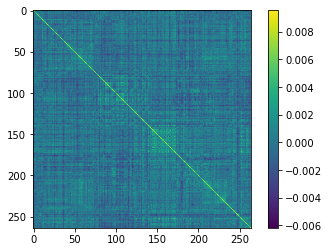

In [46]:
import matplotlib.pyplot as plt

plt.imshow(w[:264*264].reshape(264,264).detach().cpu().numpy())
plt.colorbar()
plt.show()

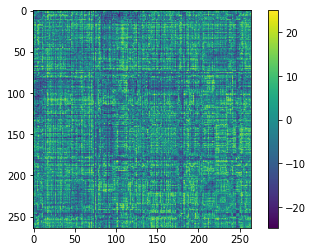

In [38]:
import matplotlib.pyplot as plt

plt.imshow((ram[264*264:]-ram[:264*264]).reshape(264,264).detach().cpu().numpy())
plt.colorbar()
plt.show()